In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128), transforms.InterpolationMode.NEAREST),  
    transforms.ToTensor(),  
])

train_dataset = OxfordIIITPet(
    root="./data", split='trainval', target_types='segmentation', transform=image_transform, download=True
)

test_dataset = OxfordIIITPet(
    root="./data", split='test', target_types='segmentation', transform=image_transform, download=True
)

In [3]:
def normalize(input_image, input_mask):
    input_mask = mask_transform(input_mask)  
    input_image = input_image.float() 
    input_mask = (input_mask * 255).long() - 1 
    return input_image, input_mask

def process_data(dataset):
    processed_data = []
    for image, mask in dataset:
        input_image, input_mask = normalize(image, mask)
        processed_data.append((input_image, input_mask))
    return processed_data

In [4]:
train_data = process_data(train_dataset)
test_data = process_data(test_dataset)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

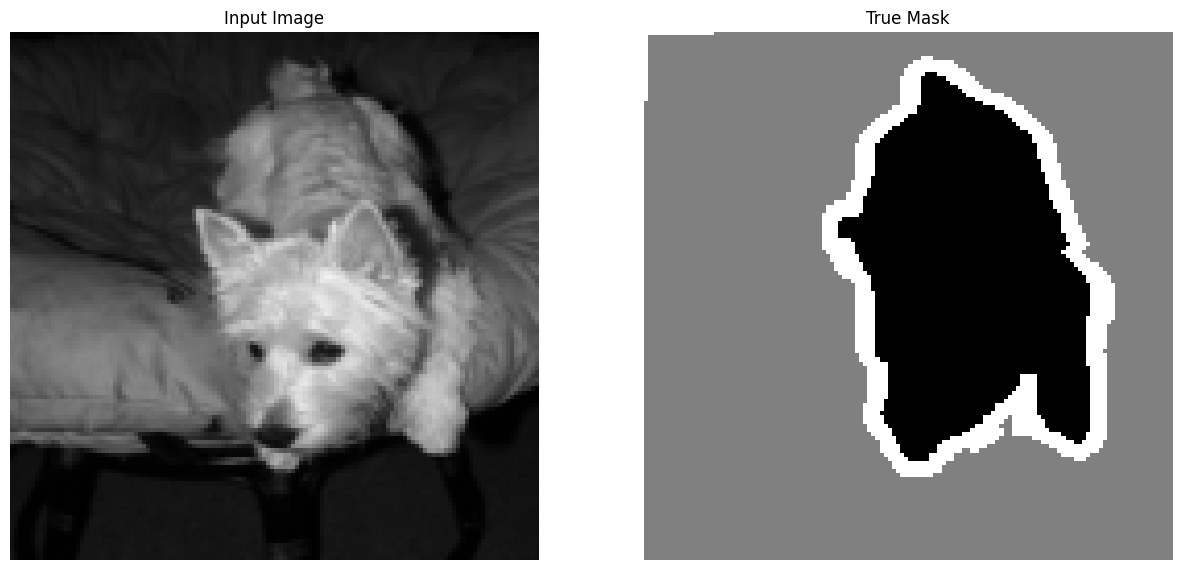

In [5]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        img = display_list[i].cpu().detach()
        img = img.numpy().transpose(1, 2, 0) 

        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap="gray")
        else:
            plt.imshow(img)

        plt.axis("off")

    plt.show()

sample_batch = next(iter(train_loader))
sample_images, sample_masks = sample_batch

random_index = np.random.randint(sample_images.shape[0])
sample_image = sample_images[random_index]
sample_mask = sample_masks[random_index]

display([sample_image, sample_mask])


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
    

class UNET(nn.Module):
    def __init__(
            self,
            in_channels=3, # N_channels
            out_channels=3, # N_classes
            features=[64, 128, 256, 512],
    ):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))

            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)
            concat_skip = torch.cat((skip_connection, x), dim=1) # along channels
            x = self.ups[idx + 1](concat_skip)
            
        x = self.final_conv(x)
        
        return F.softmax(x, dim=1)

In [7]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA (GPU)")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU") 

Using CUDA (GPU)


In [11]:
# Hyperparameters
NUM_EPOCHS = 4
LEARNING_RATE = 1e-3

In [12]:
model = UNET(in_channels=3, out_channels=3).to(DEVICE)
model = torch.compile(model)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

def train_fn(train_loader, model, optimizer, scheduler, loss_fn):
    model.train()
    loop = tqdm.tqdm(train_loader, desc="Training")

    for _, (data, targets) in enumerate(loop):
        optimizer.zero_grad()
        data = data.to(DEVICE)
        targets = targets.squeeze(1).long().to(DEVICE)

        # Forward pass
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        # Backward pass
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Update tqdm progress bar
        loop.set_postfix(loss=loss.item())

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    train_fn(train_loader, model, optimizer, scheduler, loss_fn)


Epoch [1/4]


Training: 100%|██████████| 58/58 [00:04<00:00, 14.17it/s, loss=0.816]


Epoch [2/4]


Training: 100%|██████████| 58/58 [00:03<00:00, 14.51it/s, loss=0.805]


Epoch [3/4]


Training: 100%|██████████| 58/58 [00:04<00:00, 14.39it/s, loss=0.783]


Epoch [4/4]


Training: 100%|██████████| 58/58 [00:04<00:00, 13.98it/s, loss=0.805]


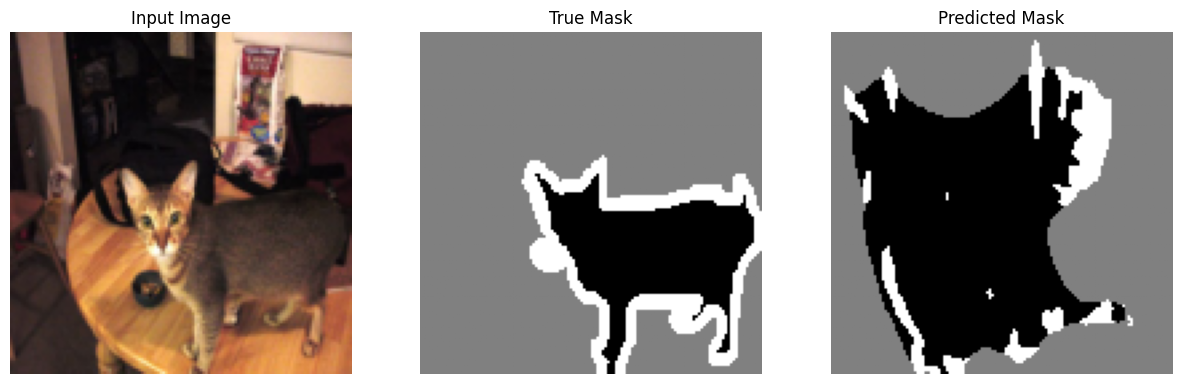

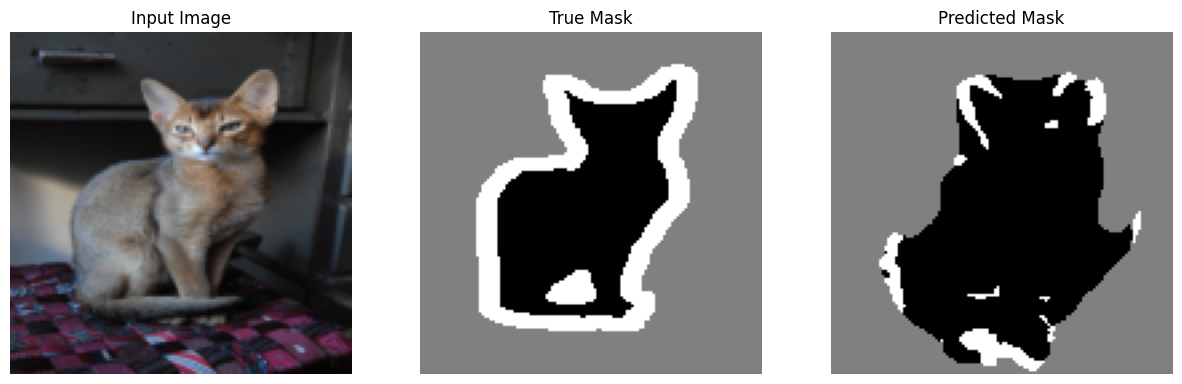

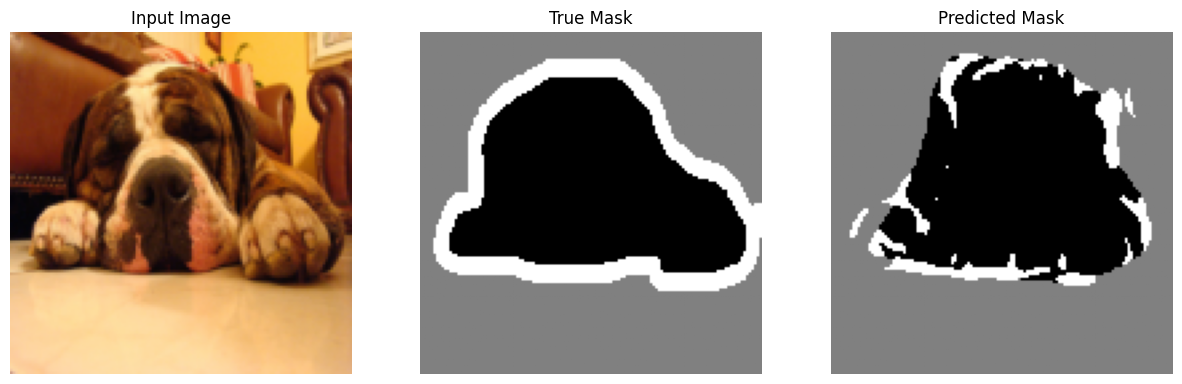

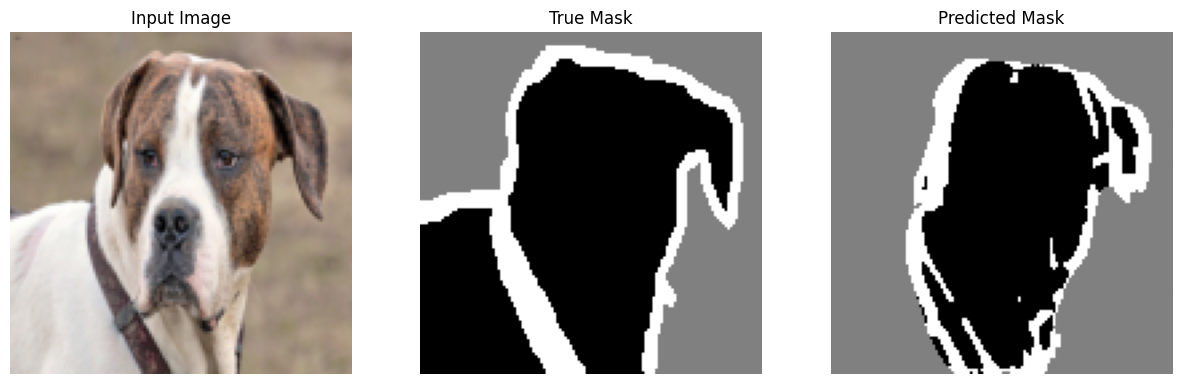

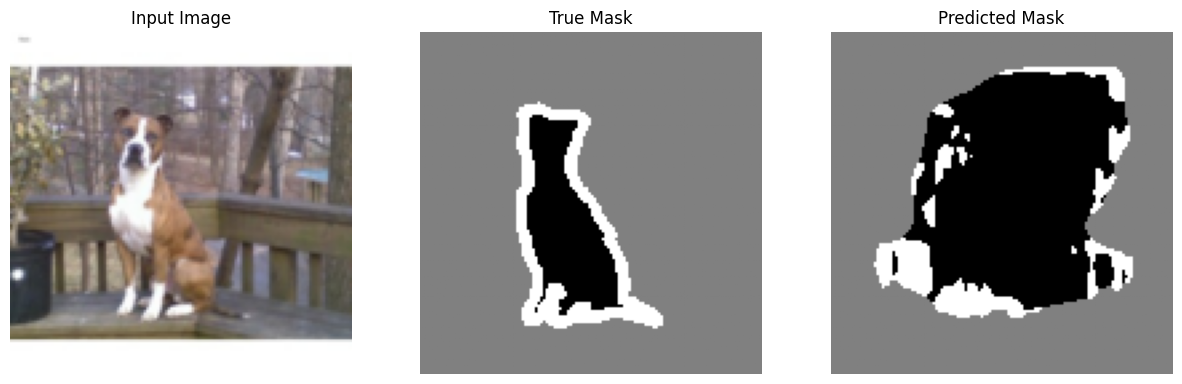

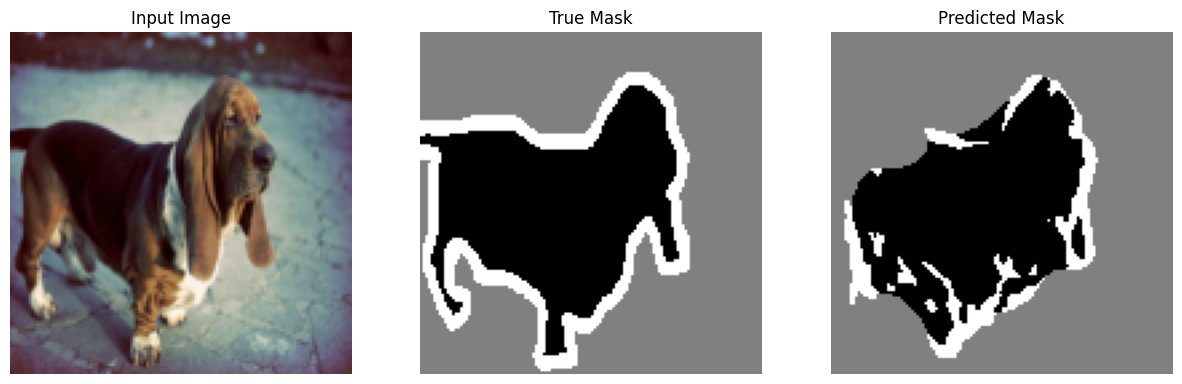

In [13]:
import torch
import matplotlib.pyplot as plt

def create_mask(pred_mask):
    """Returns the predicted mask with argmax applied along the channel dimension."""
    pred_mask = torch.argmax(pred_mask, dim=1)  # Remove channel dimension
    return pred_mask[0].cpu().numpy()  # Extract first batch and move to CPU

def show_predictions(model, dataset, num=1, device="cuda"):
    """Displays input image, true mask, and predicted mask."""
    model.eval()
    with torch.no_grad():
        for i, (image, mask) in enumerate(dataset):
            if i >= num:
                break

            image = image.to(device)
            pred_mask = model(image)  # Forward pass
            pred_mask = create_mask(pred_mask)  # Convert to NumPy array

            # Convert tensors to numpy for visualization
            image_np = image[0].cpu().permute(1, 2, 0).numpy()  # (3,128,128) -> (128,128,3)
            mask_np = mask[0].cpu().squeeze().numpy()  # Remove extra dims

            display_images([image_np, mask_np, pred_mask])

def display_images(display_list):
    """Displays a list of images with titles."""
    plt.figure(figsize=(15, 5))
    titles = ["Input Image", "True Mask", "Predicted Mask"]

    for i, img in enumerate(display_list):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(titles[i])
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)  # Handle grayscale
        plt.axis("off")

    plt.show()

# Call the function
show_predictions(model, test_loader, num=6, device=DEVICE)
